## Implement and Train CNN-LSTM Model

- Change data and folder paths as needed 

In [ ]:
!pip install dlib
!pip install imutils
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os
import imutils
import dlib # run "pip install dlib"
import cv2 # run "pip install opencv-python"
import os 
from PIL import Image

import imageio
from imutils import face_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip the preprocessed_data.zip file under data
#!unzip "/content/drive/MyDrive/Final Project/Data/preprocessed_data.zip" 
!unzip "/content/drive/My Drive/NYU/2022 Fall/DS 301 _ Parijat Dube/Final Project/Data/preprocessed_data.zip"

In [ ]:

#if os.path.exists("/content/drive/MyDrive/Final Project/Data/preprocessed_data"):
path = '/content/drive/My Drive/NYU/2022 Fall/DS 301 _ Parijat Dube/Final Project/'
if os.path.exists(path + "Data/preprocessed_data"):
  print("Data already preprocessed downloaded.")

Data already preprocessed downloaded.


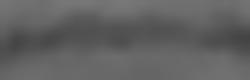

In [ ]:
#img = Image.open("/content/drive/MyDrive/Final Project/Data/preprocessed_data/F02/words/01/01/color_001.jpg")
#img = Image.open(path + "Data/preprocessed_data/F02/words/01/01/color_001.jpg")
img = Image.open("/content/preprocessed_data/F02/words/01/01/color_001.jpg")
img

In [ ]:
#dataset folder and subfolder names
people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
level = ['words']
word_nums = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']          
words_di = {i:words[i] for i in range(len(words))}

In [ ]:
words_di

{0: 'Begin',
 1: 'Choose',
 2: 'Connection',
 3: 'Navigation',
 4: 'Next',
 5: 'Previous',
 6: 'Start',
 7: 'Stop',
 8: 'Hello',
 9: 'Web'}

In [ ]:
validation_split = ['M08','F10']
test_split = ['F11']
train_split = ['F01','F02','F04','F05','F06','F07','F08','F09', 'M01','M02','M04','M07']

x_train,y_train = [],[]
x_val,y_val = [],[]
x_test,y_test = [],[]

def convert_to_train_val_dataset():
  #paths
  #folder_path = "/content/drive/MyDrive/Final Project/Data"
  #path = folder_path+"/preprocessed_data"
  #path = '/content/drive/My Drive/NYU/2022 Fall/DS 301 _ Parijat Dube/Final Project/Data/preprocessed_data'
  path = "/content/preprocessed_data"
  #parameters
  IMG_HEIGHT, IMG_WIDTH = 100,100
  MAX_SEQUENCE_LENGTH = 22 #maximum length sequence for each word instance

  #iterate through every person 
  for person_id in people:
    person_path = path+'/'+person_id
    #iterate through level (words only)
    for lvl in level:
      lvl_path = person_path+"/"+lvl
      #iterate through all words
      for i, word_num in enumerate(word_nums):
        word_path = lvl_path+"/"+word_num
        #iterate through all instances of word
        for instance_id in instances:
          instance_path = word_path+"/"+instance_id
          files = os.listdir(instance_path)
          
          #convert image sequence and store as one row of data
          img_sequence = []
          for img_name in files:
              if img_name.startswith('color'):
                print(instance_path+"/"+img_name)
                image = cv2.imread(instance_path+"/"+img_name)
                image = cv2.resize(image,dsize=(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_CUBIC)
                image.astype('float32')
                image = image/255
                #append image to sequence
                img_sequence.append(np.array(image))

          for k in range(MAX_SEQUENCE_LENGTH-len(img_sequence)):
            img_sequence.append(np.zeros((IMG_WIDTH,IMG_HEIGHT,3),dtype='float32'))
          
          img_sequence = np.array(img_sequence)
          if person_id in validation_split:
            x_val.append(img_sequence)
            y_val.append(i)
          elif person_id in train_split:
            x_train.append(img_sequence)
            y_train.append(i)
          else:
            x_test.append(img_sequence)
            y_test.append(i)
    print("Finsihed loading ", person_id, "into dataset")   

  print("Finish loading images into testing, training and validation dataset...")              


In [ ]:
convert_to_train_val_dataset()

In [ ]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print("Shape of x_train: ", x_train.shape)
print("Shape of x_val: ", x_val.shape)
print("Shape of x_test: ", x_test.shape)

print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)


Shape of x_train:  (1200, 22, 100, 100, 3)
Shape of x_val:  (200, 22, 100, 100, 3)
Shape of x_test:  (100, 22, 100, 100, 3)
Shape of y_train:  (1200,)
Shape of y_val:  (200,)
Shape of y_test:  (100,)


## Build CNN-LSTM Model

In [ ]:
#load packages
import numpy as np
import tensorflow as tf
import keras
import os # drectory library
import cv2 # image processing library
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import TimeDistributed
from keras import applications
from keras import optimizers
from keras.models import Model
from keras.models import load_model
# Fix random seed
np.random.seed(3)

In [ ]:
timesteps = 22 #length of image sequence
n_labels = 10 #Number of classes 
Learning_rate = 0.0001 
batch_size = 32
num_epochs = 50
img_col = 100 
img_row = 100
img_channel = 3 #RGB Channels

In [ ]:
#Implement CNN-LSTM Model 

#Input Layer for CNN-LSTM Model
video = Input(shape=(22,img_col,img_row,img_channel))  # 22, 100, 100, 3
#Load transfer learning model, MobileNet + ImageNet weights
model = applications.MobileNet(input_shape=(img_col,img_row,img_channel), 
                               weights="imagenet", include_top=False)
model.trainable = False
# Fully Connected Dense Layer
inputs = model.output
x = Flatten()(inputs)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
cnn_out = Dense(128, activation="relu")(x)

#CNN Layers 
Lstm_inp = Model(inputs=model.input, outputs=cnn_out)
#Distribute CNN output by timesteps, 
encoded_frames = TimeDistributed(Lstm_inp)(video)

#LSTM Layers 
encoded_sequence = LSTM(256)(encoded_frames)
hidden_dropout = Dropout(0.3)(encoded_sequence)
hidden_layer = Dense(128, activation="relu")(encoded_sequence)
outputs = Dense(n_labels, activation="softmax")(hidden_layer)

# Contruct CNN-LSTM model 
model = Model([video], outputs)

adam_opt = keras.optimizers.Adam(lr=Learning_rate, beta_1=0.9, beta_2=0.999, 
                             epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=adam_opt, 
              metrics=["accuracy"])

#Train Model
hist = model.fit(x_train, y_train, batch_size=batch_size, 
                 validation_data=(x_val, y_val), shuffle=True, 
                 epochs=num_epochs)


Epoch 1/50
38/38 [==============================] - 24s 275ms/step - loss: 2.2967 - accuracy: 0.1192 - val_loss: 2.2846 - val_accuracy: 0.1500
Epoch 2/50
38/38 [==============================] - 7s 182ms/step - loss: 2.2113 - accuracy: 0.2100 - val_loss: 2.1770 - val_accuracy: 0.2400
Epoch 3/50
38/38 [==============================] - 7s 181ms/step - loss: 1.9799 - accuracy: 0.2925 - val_loss: 2.0666 - val_accuracy: 0.2200
Epoch 4/50
38/38 [==============================] - 7s 183ms/step - loss: 1.5580 - accuracy: 0.4450 - val_loss: 2.3365 - val_accuracy: 0.1900
Epoch 5/50
38/38 [==============================] - 7s 187ms/step - loss: 1.1628 - accuracy: 0.6042 - val_loss: 1.9948 - val_accuracy: 0.2650
Epoch 6/50
38/38 [==============================] - 7s 184ms/step - loss: 0.7872 - accuracy: 0.7450 - val_loss: 2.1017 - val_accuracy: 0.2750
Epoch 7/50
38/38 [==============================] - 7s 184ms/step - loss: 0.4931 - accuracy: 0.8567 - val_loss: 2.7506 - val_accuracy: 0.2950
Epoch

# Report Model Findings

In [ ]:
Lstm_inp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 3, 1024)]      0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              9438208   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 128)               131200    
                                                                 
Total params: 9,569,408
Trainable params: 9,569,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 22, 100, 100, 3)  0         
                             ]                                   
                                                                 
 time_distributed_5 (TimeDis  (None, 22, 128)          12798272  
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 256)               394240    
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dense_25 (Dense)            (None, 10)                1290      
                                                                 
Total params: 13,226,698
Trainable params: 9,997,834
Non-t

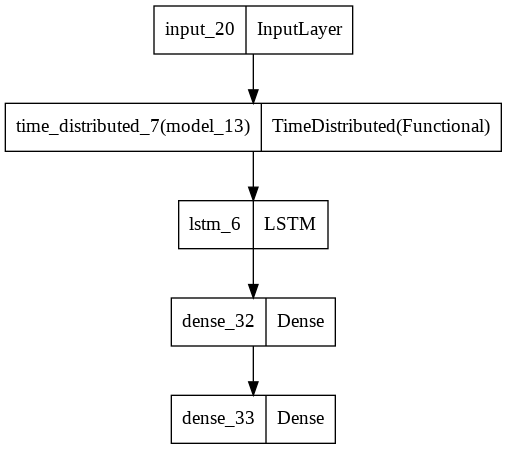

In [ ]:
# Model Architecture Visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

from keras.utils import plot_model
plot_model(model, to_file='model.png')

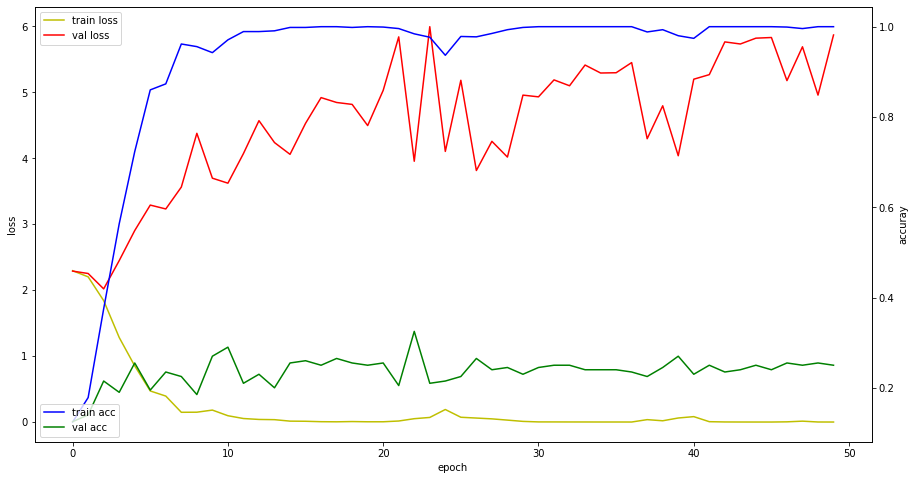

In [ ]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(15, 8))
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')  
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')  
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.savefig('accuracy')
plt.show()

#Save model

In [ ]:
#Saving the Model for future uses
model.save('Lib_Reading_22Frame_Model.h5')

In [ ]:
!pip install protobuf --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 5.1 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 which is incompatible.
tensorflow-metadata 1.12.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.12 which is incompatible.
tensorboardx 2.5.1 requires protobuf<=3.20.1,>=3.8.0, but you have protobuf 4.21.12 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 4.21.12 which is incom

In [ ]:
!pip install onnxmltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 13.5 MB 95.2 MB/s 
     |████████████████████████████████| 288 kB 100.5 MB/s 
     |████████████████████████████████| 1.0 MB 84.9 MB/s 
     |████████████████████████████████| 83 kB 3.1 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
!pip install tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 5.3 MB/s 


In [ ]:
import onnxmltools
import keras

model = keras.models.load_model('Lib_Reading_22Frame_Model.h5')
onnx_model = onnxmltools.convert_keras(model) 
onnxmltools.utils.save_model(onnx_model, 'miracl.onnx')

In [ ]:
!pip install onnx onnxruntime netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.0 MB/s 
     |████████████████████████████████| 1.5 MB 81.1 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 


In [ ]:
import onnx

onnx_model = onnx.load("miracl.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.915s


In [ ]:
import netron

netron.start('miracl.onnx', browse=True)

Serving 'miracl.onnx' at http://localhost:8081


('localhost', 8081)

In [ ]:
!lt --port 8081

your url is: https://all-donkeys-invite-34-172-212-180.loca.lt
^C
